# Loading the needed libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import csv
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# fix random values at seed 0 
# fixing the seed will make our results Reproducible 
tf.random.set_seed(0)

# Load the data from csv files

In [4]:
# load EuroSAT/rgb dataset into the model
# load training images paths from csv file
path = "./data/"
train = open(path + 'train.csv')
train_csvreader = csv.reader(train)
header = []
header = next(train_csvreader)

# load validation images paths from csv file
validation = open(path + 'validation.csv')
validation_csvreader = csv.reader(validation)
header = next(validation_csvreader)
# load test images paths from csv file
test = open(path + 'test.csv')
test_csvreader = csv.reader(test)
header = next(test_csvreader)

# loading the data as pairs (input, output)
train_rows = []
for row in train_csvreader:
        train_rows.append([row[1], row[2]])
train.close()

validation_rows = []
for row in validation_csvreader:
        validation_rows.append([row[1], row[2]])
validation.close()


test_rows = []
for row in test_csvreader:
        test_rows.append([row[1], row[2]])
test.close()

# seperating inputs and outputs
train_images = [item[0] for item in train_rows]
train_label  = [item[1] for item in train_rows]

validation_images = [item[0] for item in validation_rows]
validation_label  = [item[1] for item in validation_rows]

test_images = [item[0] for item in test_rows]
test_label  = [item[1] for item in test_rows]

train_images_array = []
# load the images from the paths (the formal inputs were strings that refered to the location of the images)
for image in train_images:
    # Open the image form working directory
    img = Image.open(path + image)
    # convert the image to array 
    img_a = tf.keras.preprocessing.image.img_to_array(img, dtype="int")
    train_images_array.append(img_a)

train_images = train_images_array
train_images_array = None # clear the variable from memory

validation_images_array = []

for image in validation_images:
    # Open the image form working directory
    img = Image.open(path + image)
    # convert the image to array 
    img_a = tf.keras.preprocessing.image.img_to_array(img, dtype="int")
    validation_images_array.append(img_a)

validation_images = validation_images_array
validation_images_array = None


test_images_array = []

for image in test_images:
    # Open the image form working directory
    img = Image.open(path + image)
    # convert the image to array 
    img_a = tf.keras.preprocessing.image.img_to_array(img, dtype="int")
    test_images_array.append(img_a)

test_images = test_images_array
test_images_array = None




# convert the images from list object to np array
train_images      = np.asarray(train_images)
train_label       = np.asarray(train_label, dtype="uint8")

validation_images = np.asarray(validation_images)
validation_label  = np.asarray(validation_label, dtype="uint8")

test_images      = np.asarray(test_images)
test_label       = np.asarray(test_label, dtype="uint8")

# making values between 0 and 1 / normalisation, to help train the model faster
train_images      = train_images/255.
validation_images = validation_images/255.
test_images       = test_images/255.

In [10]:
# load MobileNetV2 pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3),
    pooling="max"
)

In [11]:
# defining the ConvNet model layers
model = tf.keras.models.Sequential()
model.add(pretrained_model)

model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))    # output layer with 10 nodes (same as classs number) with softmax
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                        

In [12]:
# compiling the model with adam as optimizer and using cross-entropy as loss function
model.compile(
                optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"]
             )

In [ ]:
# defining the location to save the best model according to the validation accuracy, and save the logs to csv file \
# and start the training

In [13]:
#ModelCheckpoint callback saves a model at some interval. 
filepath="saved_models/transferLearning_mobilenetv2/best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# early_stopper = EarlyStopping(monitor="val_loss", patience=10, verbose=1)

csv_logger = CSVLogger('transferLearning_mobilenetv2_logs.csv', separator=",", append=False)
callbacks_list = [checkpoint, csv_logger]

history = model.fit(
                        train_images, train_label,
                        epochs=300,
                        validation_data=(validation_images, validation_label),
                        callbacks=callbacks_list
)

Epoch 1/300
591/591 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.8235
Epoch 1: val_accuracy improved from -inf to 0.41333, saving model to saved_models/transferLearning_mobilenetv2/best_model.hdf5
591/591 [==============================] - 48s 68ms/step - loss: 0.6042 - accuracy: 0.8235 - val_loss: 4.4482 - val_accuracy: 0.4133
Epoch 2/300
591/591 [==============================] - ETA: 0s - loss: 0.3897 - accuracy: 0.8932
Epoch 2: val_accuracy did not improve from 0.41333
591/591 [==============================] - 37s 63ms/step - loss: 0.3897 - accuracy: 0.8932 - val_loss: 5.3679 - val_accuracy: 0.2415
Epoch 3/300
591/591 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.9195
Epoch 3: val_accuracy improved from 0.41333 to 0.46630, saving model to saved_models/transferLearning_mobilenetv2/best_model.hdf5
591/591 [==============================] - 38s 64ms/step - loss: 0.2927 - accuracy: 0.9195 - val_loss: 2.0882 - val_accuracy: 0.4663
Ep

### Plot the training and validation Accuracy

85/85 - 2s - loss: 0.3451 - accuracy: 0.9500 - 2s/epoch - 19ms/step


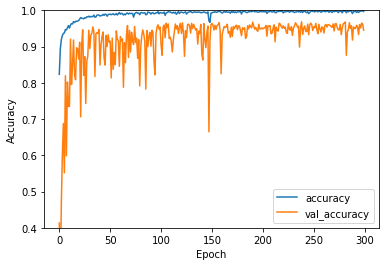

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_label, verbose=2)

### Plot The training and validation loss

85/85 - 1s - loss: 0.3451 - accuracy: 0.9500 - 1s/epoch - 16ms/step


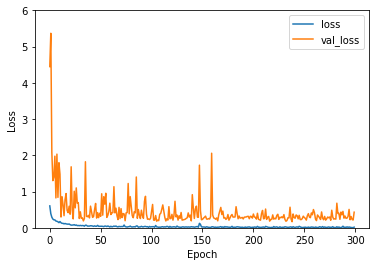

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(test_images,  test_label, verbose=2)

# Load the best model and evaluate it

In [12]:
old_model = tf.keras.models.load_model('saved_models/transferLearning_mobilenetv2/best_model.hdf5')

In [13]:
old_model.evaluate(test_images,  test_label, verbose=2)

85/85 - 2s - loss: 0.1567 - accuracy: 0.9726 - 2s/epoch - 23ms/step


[0.1567225605249405, 0.9725925922393799]

In [12]:
old_model.evaluate(train_images,  train_label, verbose=2)

591/591 - 9s - loss: 0.0018 - accuracy: 0.9995 - 9s/epoch - 15ms/step


[0.0018402095884084702, 0.9994709491729736]

In [13]:
old_model.evaluate(validation_images,  validation_label, verbose=2)

169/169 - 3s - loss: 0.1682 - accuracy: 0.9685 - 3s/epoch - 17ms/step


[0.16817429661750793, 0.9685184955596924]

In [14]:
labels =[
    "AnnualCrop",
    "Forest",
    "HerbaceousVegatation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

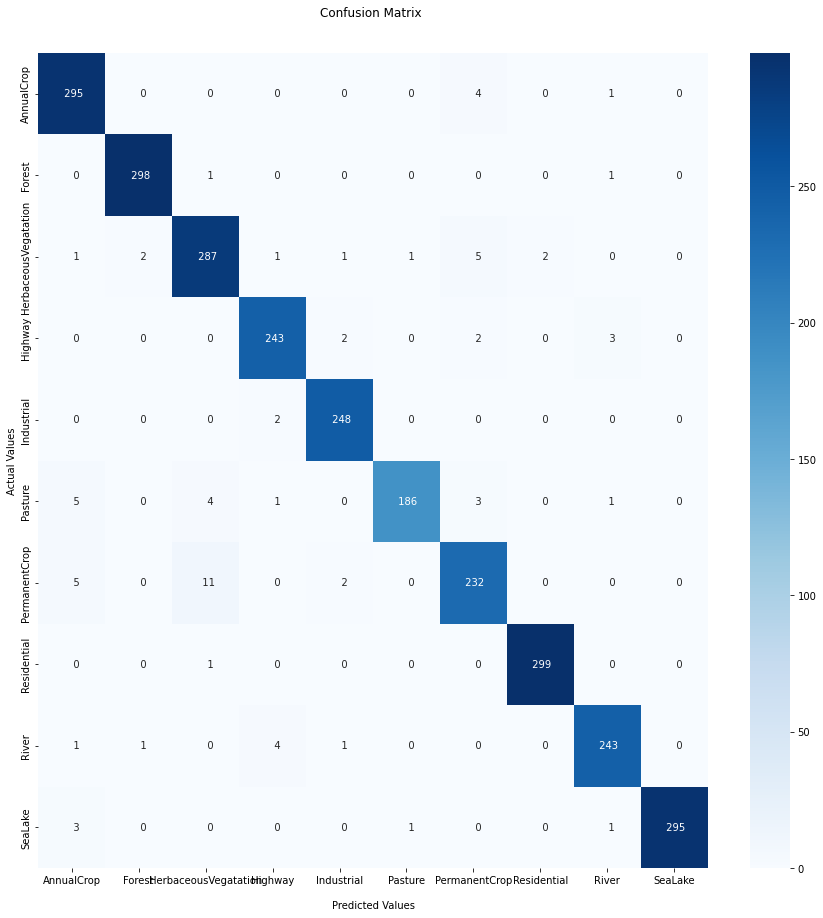

In [17]:
import seaborn as sns

predictions = np.argmax(old_model.predict(test_images) , axis=-1)
confusion_matrix = tf.math.confusion_matrix(test_label, predictions)

fig = plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='4')

ax.set_title('Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Display the visualization of the Confusion Matrix.
plt.savefig('ConfusionMatrix.png', dpi=300, bbox_inches='tight')
plt.show()

### Generate Classification report

In [15]:
from sklearn.metrics import classification_report

In [28]:
matrix = classification_report(test_label,predictions,target_names=labels,digits=6)

In [29]:
print(matrix)

                      precision    recall  f1-score   support

          AnnualCrop   0.951613  0.983333  0.967213       300
              Forest   0.990033  0.993333  0.991681       300
HerbaceousVegatation   0.944079  0.956667  0.950331       300
             Highway   0.968127  0.972000  0.970060       250
          Industrial   0.976378  0.992000  0.984127       250
             Pasture   0.989362  0.930000  0.958763       200
       PermanentCrop   0.943089  0.928000  0.935484       250
         Residential   0.993355  0.996667  0.995008       300
               River   0.972000  0.972000  0.972000       250
             SeaLake   1.000000  0.983333  0.991597       300

            accuracy                       0.972593      2700
           macro avg   0.972804  0.970733  0.971626      2700
        weighted avg   0.972776  0.972593  0.972563      2700

